# <center>Image Segmentation with U-Net</center>

<img src="images/carseg.png" style="width:500px;height:250;">
<caption><center>Example of a segmented image</center></caption>

## Model Details

<img src="images/unet.png" style="width:700px;height:400;">
<caption><center>U-Net Architecture<br> </center></caption>

### Imports

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input,  Conv2D, Conv2DTranspose, concatenate, Dropout, MaxPooling2D

In [4]:
image_dir = 'data/CameraRGB/'
mask_dir = 'data/CameraMask/'

image_files = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
mask_files  = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

In [5]:
print('Total Images:', len(image_files))

Total Images: 1060


Size of Image: (480, 640, 3)
Size of Mask: (480, 640)


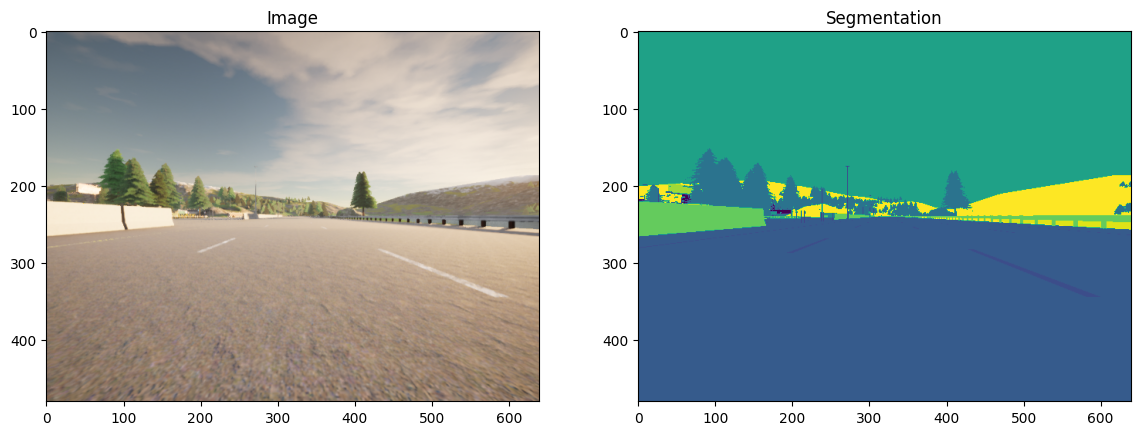

In [6]:
N = 5
img = imageio.imread(image_files[N])[:, :, :3]
mask = imageio.imread(mask_files[N])[:, :,0]
print('Size of Image:', img.shape)
print('Size of Mask:', mask.shape)

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask)
arr[1].set_title('Segmentation')
plt.show()

In [7]:
def load_image(img_path, mask_path, img_size=(96, 128)):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, img_size, method='nearest') 
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)

    return img, mask

(96, 128, 3)
(96, 128, 1)


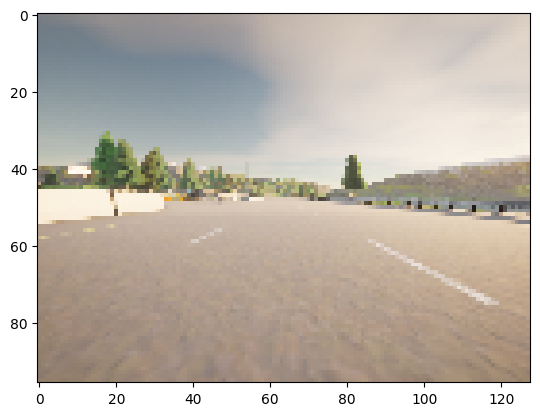

In [8]:
img, mask = load_image(image_files[0], mask_files[0])
print(img.shape)
print(mask.shape)
plt.imshow(img)
plt.show()

In [55]:
def get_unique_labels_from_masks(mask_paths):
    unique_labels = set()
    for mask_path in mask_paths:
        mask = np.array(Image.open(mask_path))
        unique = np.unique(mask)
        unique_labels.update(unique.tolist())
    return sorted(list(unique_labels))

mask_paths = mask_files
unique_labels = get_unique_labels_from_masks(mask_paths)

print(f"Unique labels: {unique_labels}")
print(f"Number of classes: {len(unique_labels)}")

Unique labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 255]
Number of classes: 24


In [10]:
def load_segmentation_datasets(
    image_dir_1='data/CameraRGB/',
    mask_dir_1='data/CameraMask/',
    img_size=(96, 128),
    batch_size=32,
    val_split=0.2,
    seed=42
):
    image_files = sorted([os.path.join(image_dir_1, fname) for fname in os.listdir(image_dir_1)])
    mask_files  = sorted([os.path.join(mask_dir_1, fname) for fname in os.listdir(mask_dir_1)])

    # shuffle and split
    train_images, val_images, train_masks, val_masks = train_test_split(
        image_files, mask_files, test_size=val_split, random_state=seed, shuffle=True
    )
    
    print(f"Train examples: {len(train_images)}")
    print(f"Val examples: {len(val_images)}")

    # preprocessing function
    def load_image_and_mask(img_path, mask_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.resize(img, img_size)
        img = tf.cast(img, tf.float32) / 255.0

        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_png(mask, channels=1)
        mask = tf.image.resize(mask, img_size, method='nearest')
        mask = tf.cast(mask, tf.uint8)
        return img, mask

    # create TensorFlow Datasets
    def create_dataset(image_paths, mask_paths):
        ds = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
        ds = ds.shuffle(buffer_size=len(image_paths), seed=seed)
        ds = ds.map(lambda x, y: load_image_and_mask(x, y), num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return ds

    train_dataset = create_dataset(train_images, train_masks)
    val_dataset   = create_dataset(val_images, val_masks)
    
    train_count = tf.data.experimental.cardinality(train_dataset).numpy()
    val_count = tf.data.experimental.cardinality(val_dataset).numpy()

    print(f"Train Batches: {train_count}")
    print(f"Val Batches: {val_count}")

    return train_dataset, val_dataset

In [11]:
train_ds, val_ds = load_segmentation_datasets(val_split=0.1)

Train examples: 954
Val examples: 106
Train Batches: 30
Val Batches: 4


In [12]:
print("\n--- First batch shapes ---")
for images, masks in train_ds.take(1):
    print(f"Train Image Batch Shape: {images.shape}")
    print(f"Train Mask Batch Shape: {masks.shape}")

for images, masks in val_ds.take(1):
    print(f"Validation Image Batch Shape: {images.shape}")
    print(f"Validation Mask Batch Shape: {masks.shape}")


--- First batch shapes ---
Train Image Batch Shape: (32, 96, 128, 3)
Train Mask Batch Shape: (32, 96, 128, 1)
Validation Image Batch Shape: (32, 96, 128, 3)
Validation Mask Batch Shape: (32, 96, 128, 1)


(32, 96, 128, 3)
(32, 96, 128, 1)


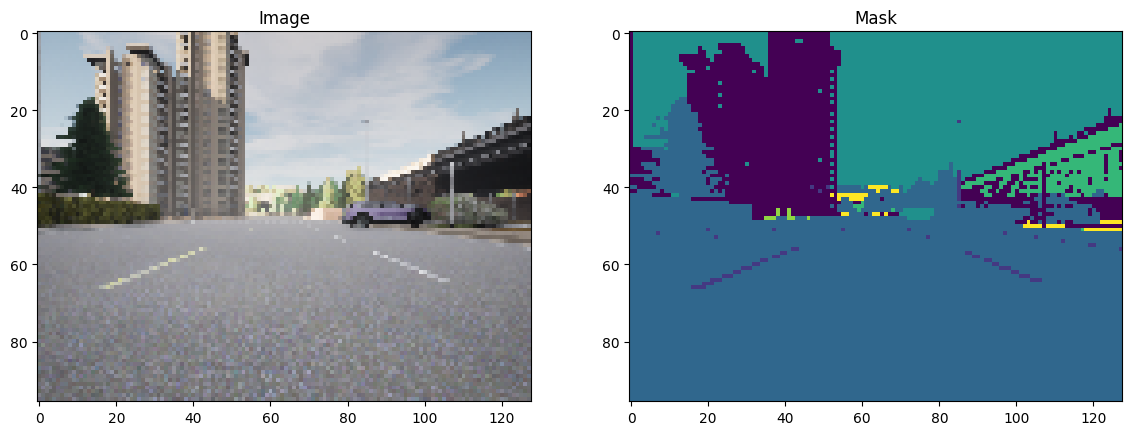

In [13]:
for images, masks in train_ds.take(1):
    print(images.shape)
    print(masks.shape)
    
    plt.figure(figsize=(14, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(images[0])
    plt.title("Image")
    plt.subplot(1, 2, 2)
    plt.imshow(masks[0])
    plt.title("Mask")
    plt.show()

## conv_block

## Encoder (Downsampling Block) 

<img src="images/encoder.png" style="width:500px;height:500;">
<caption><center>The U-Net Encoder up close <br> </center></caption>

In [102]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Builds a convolutional downsampling block for the U-Net encoder.

    This block applies two Conv2D layers with ReLU activation, optional dropout,
    and optional MaxPooling2D for spatial downsampling.

    Args:
        inputs (tf.Tensor): Input tensor of shape (batch_size, H, W, C).
        n_filters (int): Number of filters for both Conv2D layers.
        dropout_prob (float): Dropout rate applied after Conv2D layers if > 0.
        max_pooling (bool): If True, applies MaxPooling2D with pool size = 2 and strides=2
                            to downsample the spatial dimensions.

    Returns:
        next_layer (tf.Tensor): 
            - If max_pooling is True: shape → (batch_size, H/2, W/2, n_filters)
            - Else: shape → (batch_size, H, W, n_filters)
        
        skip_connection (tf.Tensor): Output before pooling, used in skip connection.
            - shape → (batch_size, H, W, n_filters)
    """
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    
    if dropout_prob > 0:
        conv = Dropout(rate=dropout_prob)(conv)
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=2)(conv)
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

## upsampling_block

## Decoder (Upsampling Block)

The decoder, or upsampling block, upsamples the features back to the original image size. At each upsampling level, we'll take the output of the corresponding encoder block and concatenate it before feeding to the next decoder block.

<img src="images/decoder.png" style="width:500px;height:500;">
<caption><center>The U-Net Decoder up close <br> </center></caption>

In [103]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Builds an upsampling block for the U-Net decoder.

    Applies transpose convolution to upscale the input, concatenates it with
    the corresponding encoder output (skip connection), and applies two Conv2D layers.

    Args:
        expansive_input (tf.Tensor): Decoder input tensor, shape (B, H, W, C).
        contractive_input (tf.Tensor): Encoder skip connection tensor, shape (B, H, W, C).
        n_filters (int): Number of filters for the Conv2D layers.

    Returns:
        tf.Tensor: Output tensor of shape (B, H*2, W*2, n_filters).
    """
    up = Conv2DTranspose(n_filters, 3, strides=2, padding='same')(expansive_input)
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    
    return conv

## Model Building

In [104]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23, debug=False):
    """
    Builds a U-Net model for semantic segmentation.

    U-Net follows an encoder–decoder architecture:
    - The encoder path (contracting) applies repeated 3x3 Conv + ReLU + MaxPool to extract spatial features while reducing resolution.
    - The decoder path (expanding) upsamples the feature maps using transpose convolutions, and merges them with corresponding encoder features (skip connections) to recover spatial details.
    - A final 1x1 convolution maps the features to the desired number of output classes.

    Args:
        input_size (tuple): Shape of the input image (height, width, channels).
        n_filters (int): Number of filters for the first conv block (doubles at each level).
        n_classes (int): Number of segmentation output classes.

    Returns:
        tf.keras.Model: Compiled U-Net model.
    """

    inputs = Input(input_size)
    if debug: print("Input:", inputs.shape)

    cblock1 = conv_block(inputs, n_filters)
    if debug: print("After cblock1:", cblock1[0].shape, "(skip:", cblock1[1].shape, ")")

    cblock2 = conv_block(cblock1[0], n_filters*2)
    if debug: print("After cblock2:", cblock2[0].shape, "(skip:", cblock2[1].shape, ")")

    cblock3 = conv_block(cblock2[0], n_filters*4)
    if debug: print("After cblock3:", cblock3[0].shape, "(skip:", cblock3[1].shape, ")")

    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0.3)
    if debug: print("After cblock4:", cblock4[0].shape, "(skip:", cblock4[1].shape, ")")

    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)
    if debug: print("After cblock5 (bottom):", cblock5[0].shape)

    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)
    if debug: print("After ublock6:", ublock6.shape)

    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
    if debug: print("After ublock7:", ublock7.shape)

    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    if debug: print("After ublock8:", ublock8.shape)

    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters)
    if debug: print("After ublock9:", ublock9.shape)

    conv9 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(ublock9)
    if debug: print("After conv9:", conv9.shape)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    if debug: print("Final Output:", conv10.shape)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    return model

In [105]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels), debug=True)

Input: (None, 96, 128, 3)
After cblock1: (None, 48, 64, 32) (skip: (None, 96, 128, 32) )
After cblock2: (None, 24, 32, 64) (skip: (None, 48, 64, 64) )
After cblock3: (None, 12, 16, 128) (skip: (None, 24, 32, 128) )
After cblock4: (None, 6, 8, 256) (skip: (None, 12, 16, 256) )
After cblock5 (bottom): (None, 6, 8, 512)
After ublock6: (None, 12, 16, 256)
After ublock7: (None, 24, 32, 128)
After ublock8: (None, 48, 64, 64)
After ublock9: (None, 96, 128, 32)
After conv9: (None, 96, 128, 32)
Final Output: (None, 96, 128, 23)


In [106]:
unet.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_82 (Conv2D)             (None, 96, 128, 32)  896         ['input_6[0][0]']                
                                                                                                  
 conv2d_83 (Conv2D)             (None, 96, 128, 32)  9248        ['conv2d_82[0][0]']              
                                                                                                  
 max_pooling2d_17 (MaxPooling2D  (None, 48, 64, 32)  0           ['conv2d_83[0][0]']        

                                                                                                  
 conv2d_101 (Conv2D)            (None, 96, 128, 23)  759         ['conv2d_100[0][0]']             
                                                                                                  
Total params: 8,640,471
Trainable params: 8,640,471
Non-trainable params: 0
__________________________________________________________________________________________________


In [18]:
class CustomMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, name='mean_iou', dtype=None):
        super().__init__(num_classes=num_classes, name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Apply argmax to predictions (convert logits to class predictions)
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)


In [108]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = tf.keras.optimizers.Adam()

unet.compile(
    optimizer=opt,
    loss=loss_fn,
    metrics=[
        'sparse_categorical_accuracy',
        CustomMeanIoU(num_classes=23)
    ]
)

In [28]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(96, 128, 3)
(96, 128, 1)


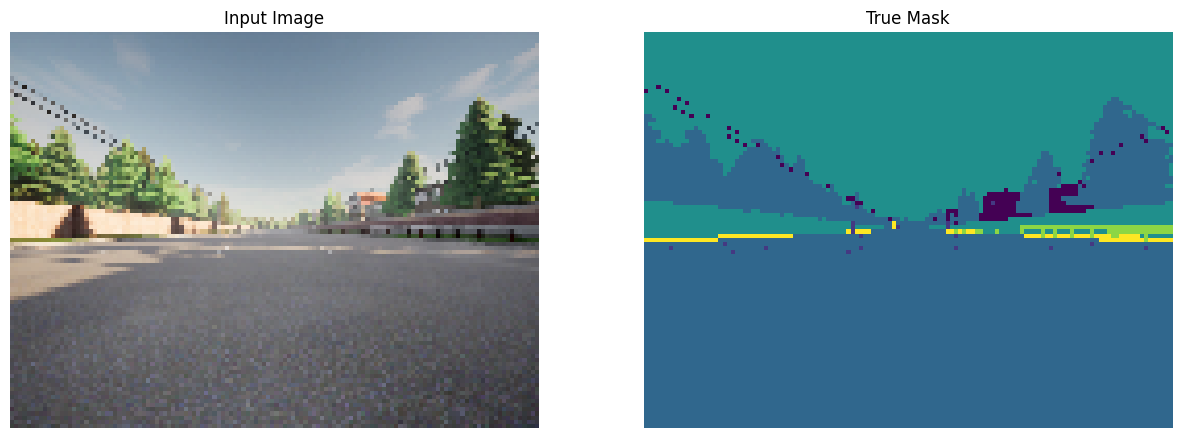

In [29]:
for img, mask in train_ds.take(1):
    image, mask = img[0], mask[0]
    print(image.shape)
    print(mask.shape)

display([image, mask])

## Train the Model

In [112]:
init_epochs = 10

In [113]:
init_history = unet.fit(train_ds, validation_data=val_ds, epochs=init_epochs)

Epoch 1/10
30/30 [==============================] - 14s 371ms/step - loss: 2.8609 - sparse_categorical_accuracy: 0.3673 - mean_iou: 0.0332 - val_loss: 1.2916 - val_sparse_categorical_accuracy: 0.7248 - val_mean_iou: 0.1813
Epoch 2/10
30/30 [==============================] - 11s 336ms/step - loss: 0.8491 - sparse_categorical_accuracy: 0.7865 - mean_iou: 0.2126 - val_loss: 0.7781 - val_sparse_categorical_accuracy: 0.7835 - val_mean_iou: 0.2189
Epoch 3/10
30/30 [==============================] - 11s 336ms/step - loss: 0.6477 - sparse_categorical_accuracy: 0.8114 - mean_iou: 0.2395 - val_loss: 0.6203 - val_sparse_categorical_accuracy: 0.8157 - val_mean_iou: 0.2507
Epoch 4/10
30/30 [==============================] - 11s 333ms/step - loss: 0.5188 - sparse_categorical_accuracy: 0.8436 - mean_iou: 0.2769 - val_loss: 0.5064 - val_sparse_categorical_accuracy: 0.8394 - val_mean_iou: 0.2782
Epoch 5/10
30/30 [==============================] - 11s 316ms/step - loss: 0.4834 - sparse_categorical_accur

In [114]:
more_epochs = 20
history_finetune = unet.fit(train_ds, validation_data=val_ds, epochs=10 + more_epochs, initial_epoch=init_epochs)

Epoch 11/30
30/30 [==============================] - 11s 329ms/step - loss: 0.2160 - sparse_categorical_accuracy: 0.9315 - mean_iou: 0.5522 - val_loss: 0.2166 - val_sparse_categorical_accuracy: 0.9335 - val_mean_iou: 0.5903
Epoch 12/30
30/30 [==============================] - 11s 322ms/step - loss: 0.2052 - sparse_categorical_accuracy: 0.9352 - mean_iou: 0.5672 - val_loss: 0.1944 - val_sparse_categorical_accuracy: 0.9404 - val_mean_iou: 0.6135
Epoch 13/30
30/30 [==============================] - 11s 336ms/step - loss: 0.1803 - sparse_categorical_accuracy: 0.9442 - mean_iou: 0.6048 - val_loss: 0.1785 - val_sparse_categorical_accuracy: 0.9441 - val_mean_iou: 0.6308
Epoch 14/30
30/30 [==============================] - 11s 329ms/step - loss: 0.1682 - sparse_categorical_accuracy: 0.9482 - mean_iou: 0.6218 - val_loss: 0.1752 - val_sparse_categorical_accuracy: 0.9440 - val_mean_iou: 0.6279
Epoch 15/30
30/30 [==============================] - 11s 339ms/step - loss: 0.1573 - sparse_categorical_

In [39]:
def plot_training_history(history):
    epochs = range(1, len(history['loss']) + 1)

    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot Loss (left y-axis)
    ax1.plot(epochs, history['loss'], 'b-', label='Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='b')
    ax1.tick_params('y', colors='b')

    # Plot Accuracy (right y-axis)
    ax2 = ax1.twinx()
    ax2.plot(epochs, history['sparse_categorical_accuracy'], 'g-', label='sparse_categorical_accuracy')
    ax2.set_ylabel('sparse_categorical_accuracy', color='g')
    ax2.tick_params('y', colors='g')

    # Plot Mean IoU (right y-axis, same as accuracy)
    if 'mean_iou' in history:
        ax2.plot(epochs, history['mean_iou'], 'r-', label='Mean IoU')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper center')

    plt.title('Training Loss, sparse_categorical_accuracy, and Mean IoU')
    fig.tight_layout()
    plt.show()

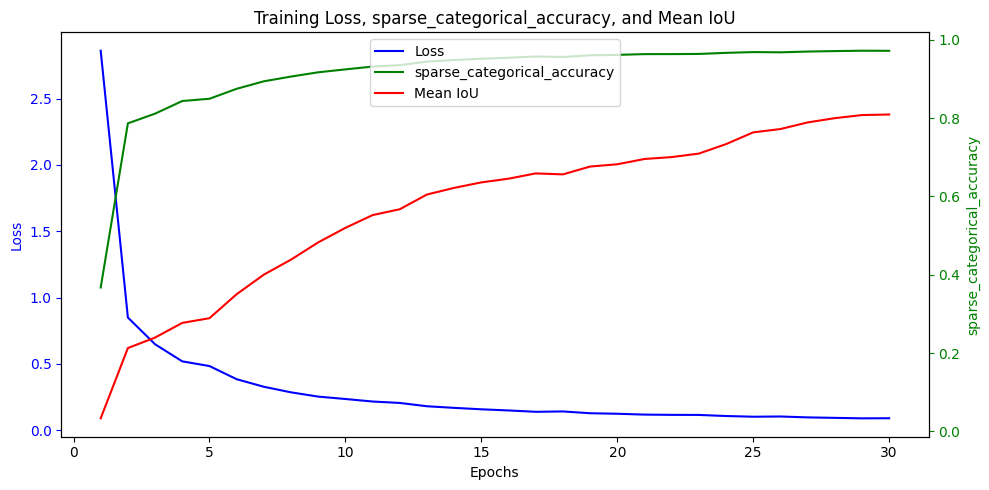

In [117]:
full_history = {
    key: init_history.history[key] + history_finetune.history[key]
    for key in init_history.history
}
plot_training_history(full_history)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_cb = ModelCheckpoint(
    filepath='best_unet_model.h5',
    monitor='val_mean_iou',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# Stop training if no improvement in val_mean_ioU for 6 epochs
earlystop_cb = EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [119]:
even_more_epochs = 20
history_continue = unet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30 + even_more_epochs,
    initial_epoch=30,
    callbacks=[checkpoint_cb, earlystop_cb]
)


Epoch 31/50
30/30 [==============================] - ETA: 0s - loss: 0.0887 - sparse_categorical_accuracy: 0.9721 - mean_iou: 0.8107
Epoch 31: val_mean_iou improved from -inf to 0.84263, saving model to best_unet_model.h5
30/30 [==============================] - 11s 337ms/step - loss: 0.0887 - sparse_categorical_accuracy: 0.9721 - mean_iou: 0.8107 - val_loss: 0.0864 - val_sparse_categorical_accuracy: 0.9732 - val_mean_iou: 0.8426
Epoch 32/50
29/30 [============================>.] - ETA: 0s - loss: 0.0843 - sparse_categorical_accuracy: 0.9735 - mean_iou: 0.8213
Epoch 32: val_mean_iou improved from 0.84263 to 0.84538, saving model to best_unet_model.h5
30/30 [==============================] - 11s 348ms/step - loss: 0.0843 - sparse_categorical_accuracy: 0.9735 - mean_iou: 0.8206 - val_loss: 0.0823 - val_sparse_categorical_accuracy: 0.9737 - val_mean_iou: 0.8454
Epoch 33/50
29/30 [============================>.] - ETA: 0s - loss: 0.0844 - sparse_categorical_accuracy: 0.9734 - mean_iou: 0.8

In [38]:
def plot_training_history_val(history):
    epochs = range(1, len(history['val_loss']) + 1)

    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot Loss (left y-axis)
    ax1.plot(epochs, history['val_loss'], 'b-', label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Validation Loss', color='b')
    ax1.tick_params('y', colors='b')

    # Plot Accuracy (right y-axis)
    ax2 = ax1.twinx()
    ax2.plot(epochs, history['val_sparse_categorical_accuracy'], 'g-', label='val_sparse_categorical_accuracy')
    ax2.set_ylabel('val_sparse_categorical_accuracy', color='g')
    ax2.tick_params('y', colors='g')

    # Plot Mean IoU (right y-axis, same as accuracy)
    if 'mean_iou' in history:
        ax2.plot(epochs, history['val_mean_iou'], 'r-', label='Validation Mean IoU')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper center')

    plt.title('Validation Loss, sparse_categorical_accuracy, and Mean IoU')
    fig.tight_layout()
    plt.show()

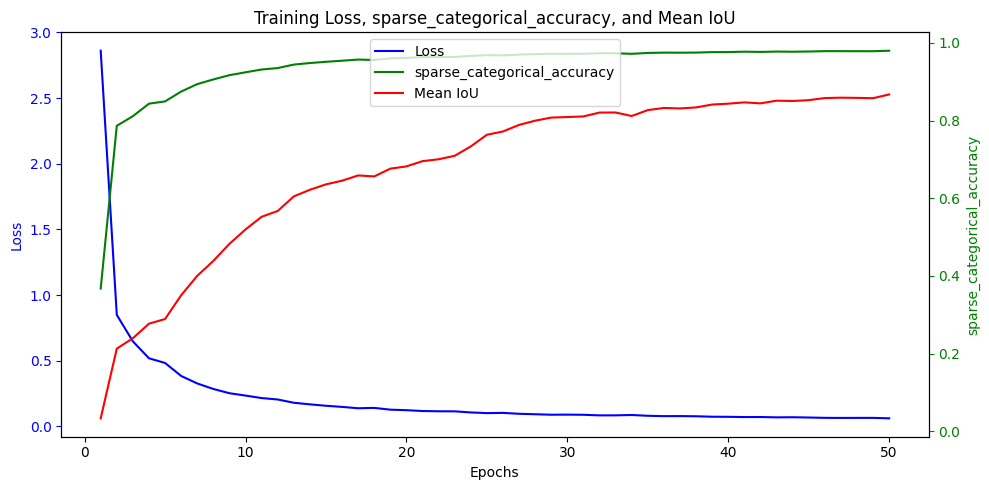

In [126]:
full_history = {
    key: init_history.history.get(key, []) 
         + history_finetune.history.get(key, []) 
         + history_continue.history.get(key, [])
    for key in set(init_history.history) | set(history_finetune.history) | set(history_continue.history)
}

plot_training_history(full_history)

In [ ]:
plot_training_history_val(full_history)

In [20]:
from tensorflow.keras.models import load_model

best_model = load_model('best_unet_model.h5', custom_objects={'CustomMeanIoU': CustomMeanIoU(num_classes=23)})

In [22]:
val_loss, val_accuracy, val_mean_iou = best_model.evaluate(train_ds)

print(f"Train Loss: {val_loss:.4f}")
print(f"Train Accuracy: {val_accuracy:.4f}")
print(f"Train Mean IoU: {val_mean_iou:.4f}")

30/30 [==============================] - 10s 308ms/step - loss: 0.0614 - sparse_categorical_accuracy: 0.9799 - mean_iou: 0.8660
Train Loss: 0.0614
Train Accuracy: 0.9799
Train Mean IoU: 0.8660


In [23]:
val_loss, val_accuracy, val_mean_iou = best_model.evaluate(val_ds)

print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Mean IoU: {val_mean_iou:.4f}")

4/4 [==============================] - 1s 45ms/step - loss: 0.0629 - sparse_categorical_accuracy: 0.9798 - mean_iou: 0.8815
Val Loss: 0.0629
Val Accuracy: 0.9798
Val Mean IoU: 0.8815


In [30]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [35]:
def show_predictions(dataset=None, num=5):
    """
    Displays the first image of each of the num batches
    """
    for image, mask in dataset.take(num):
        pred_mask = best_model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])

1/1 [==============================] - 0s 408ms/step


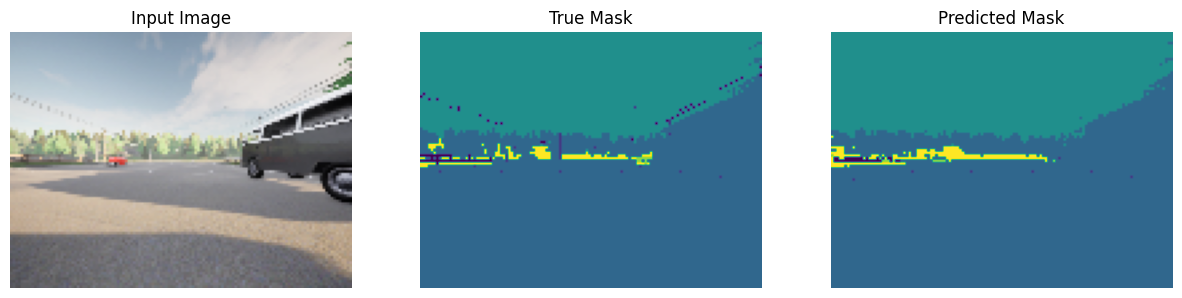

1/1 [==============================] - 0s 25ms/step


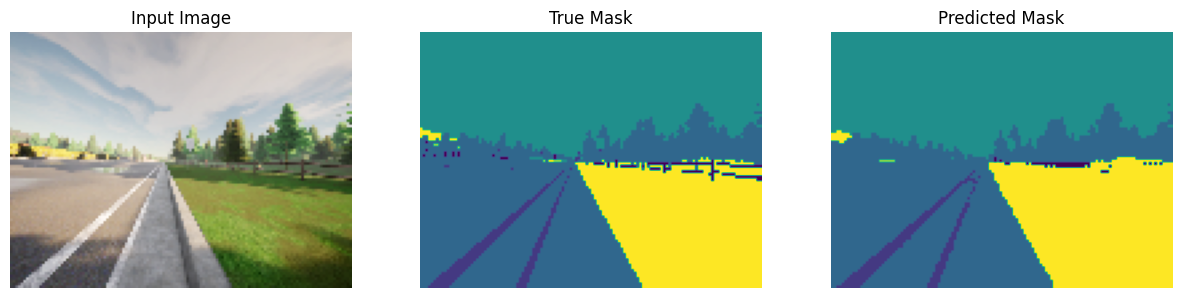

1/1 [==============================] - 0s 108ms/step


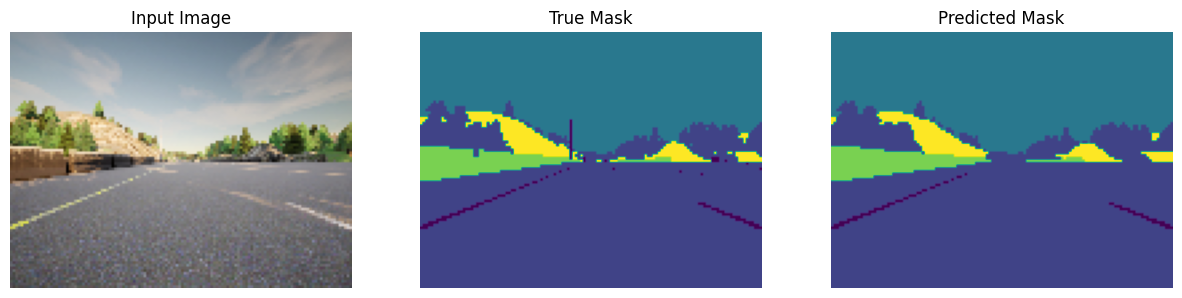

In [36]:
show_predictions(train_ds, 3)

In [37]:
extra_epochs = 10
history_more = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50 + extra_epochs,
    initial_epoch=50,
    callbacks=[checkpoint_cb, earlystop_cb]
)

Epoch 51/60
30/30 [==============================] - ETA: 0s - loss: 0.0628 - sparse_categorical_accuracy: 0.9795 - mean_iou: 0.8635
Epoch 51: val_mean_iou improved from -inf to 0.88242, saving model to best_unet_model.h5
30/30 [==============================] - 14s 337ms/step - loss: 0.0628 - sparse_categorical_accuracy: 0.9795 - mean_iou: 0.8635 - val_loss: 0.0626 - val_sparse_categorical_accuracy: 0.9798 - val_mean_iou: 0.8824
Epoch 52/60
29/30 [============================>.] - ETA: 0s - loss: 0.0613 - sparse_categorical_accuracy: 0.9800 - mean_iou: 0.8672
Epoch 52: val_mean_iou improved from 0.88242 to 0.88399, saving model to best_unet_model.h5
30/30 [==============================] - 11s 339ms/step - loss: 0.0617 - sparse_categorical_accuracy: 0.9798 - mean_iou: 0.8663 - val_loss: 0.0626 - val_sparse_categorical_accuracy: 0.9797 - val_mean_iou: 0.8840
Epoch 53/60
30/30 [==============================] - ETA: 0s - loss: 0.0616 - sparse_categorical_accuracy: 0.9797 - mean_iou: 0.8

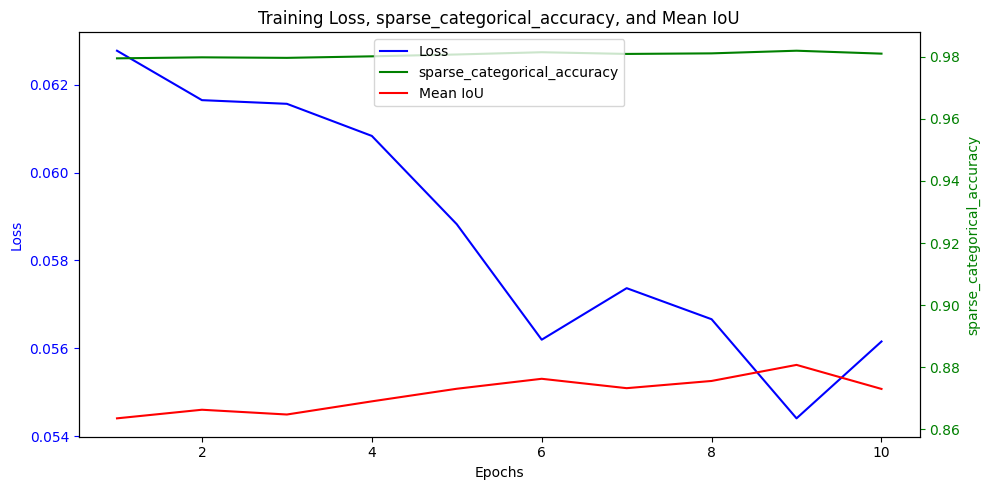

In [40]:
plot_training_history(history_more.history)

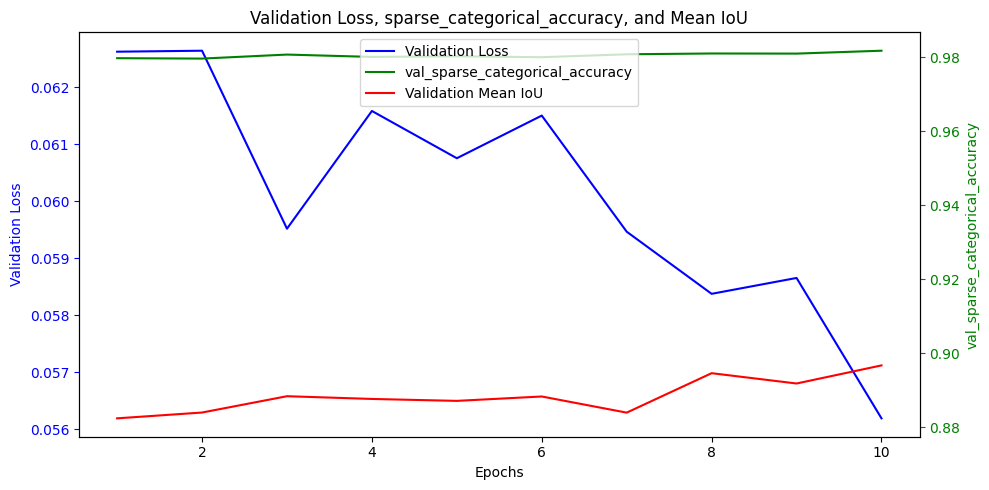

In [41]:
plot_training_history_val(history_more.history)

In [42]:
extra_epochs_2 = 10
history_more_2 = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=60 + extra_epochs_2,
    initial_epoch=60,
    callbacks=[checkpoint_cb, earlystop_cb]
)

Epoch 61/70
29/30 [============================>.] - ETA: 0s - loss: 0.0536 - sparse_categorical_accuracy: 0.9822 - mean_iou: 0.8808
Epoch 61: val_mean_iou did not improve from 0.89673
30/30 [==============================] - 11s 321ms/step - loss: 0.0536 - sparse_categorical_accuracy: 0.9822 - mean_iou: 0.8816 - val_loss: 0.0553 - val_sparse_categorical_accuracy: 0.9822 - val_mean_iou: 0.8965
Epoch 62/70
30/30 [==============================] - ETA: 0s - loss: 0.0544 - sparse_categorical_accuracy: 0.9819 - mean_iou: 0.8821
Epoch 62: val_mean_iou did not improve from 0.89673
30/30 [==============================] - 11s 322ms/step - loss: 0.0544 - sparse_categorical_accuracy: 0.9819 - mean_iou: 0.8821 - val_loss: 0.0649 - val_sparse_categorical_accuracy: 0.9787 - val_mean_iou: 0.8806
Epoch 63/70
30/30 [==============================] - ETA: 0s - loss: 0.0643 - sparse_categorical_accuracy: 0.9785 - mean_iou: 0.8601
Epoch 63: val_mean_iou did not improve from 0.89673
30/30 [==============

In [44]:
full_history = {
    key: history_more.history.get(key, []) 
         + history_more_2.history.get(key, [])
    for key in set(history_more.history) | set(history_more.history)
}

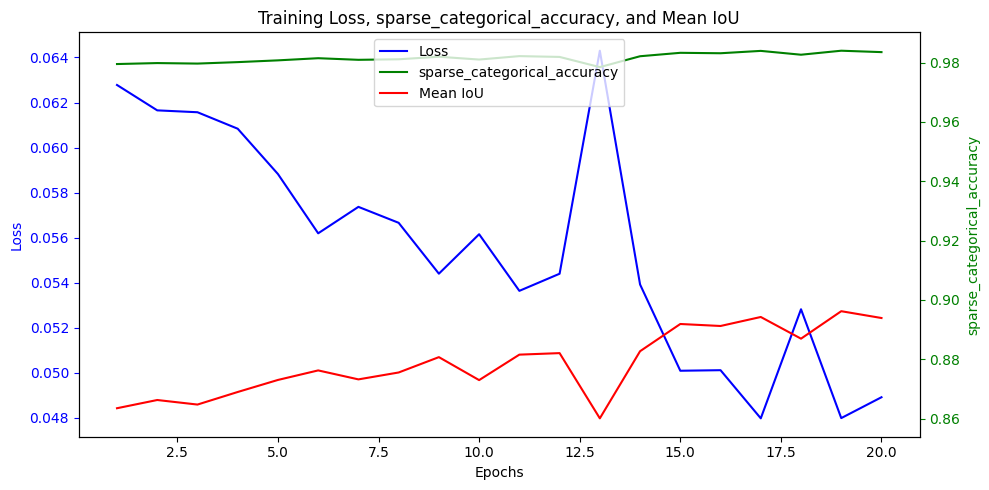

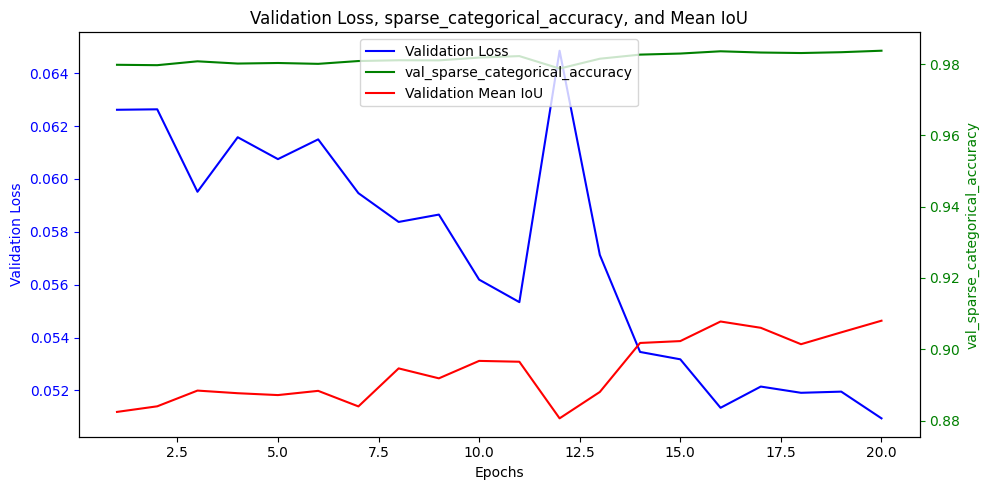

In [45]:
plot_training_history(full_history)
plot_training_history_val(full_history)

In [46]:
from tensorflow.keras.models import load_model

best_model = load_model('best_unet_model.h5', custom_objects={'CustomMeanIoU': CustomMeanIoU(num_classes=23)})

In [47]:
val_loss, val_accuracy, val_mean_iou = best_model.evaluate(train_ds)

print(f"Train Loss: {val_loss:.4f}")
print(f"Train Accuracy: {val_accuracy:.4f}")
print(f"Train Mean IoU: {val_mean_iou:.4f}")

30/30 [==============================] - 10s 294ms/step - loss: 0.0468 - sparse_categorical_accuracy: 0.9842 - mean_iou: 0.8967
Train Loss: 0.0468
Train Accuracy: 0.9842
Train Mean IoU: 0.8967


In [48]:
val_loss, val_accuracy, val_mean_iou = best_model.evaluate(val_ds)

print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Mean IoU: {val_mean_iou:.4f}")

4/4 [==============================] - 1s 49ms/step - loss: 0.0509 - sparse_categorical_accuracy: 0.9837 - mean_iou: 0.9080
Val Loss: 0.0509
Val Accuracy: 0.9837
Val Mean IoU: 0.9080


1/1 [==============================] - 0s 183ms/step


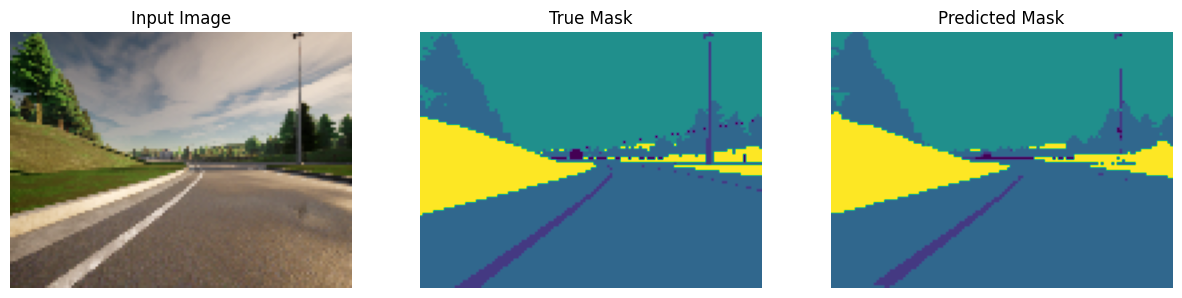

1/1 [==============================] - 0s 26ms/step


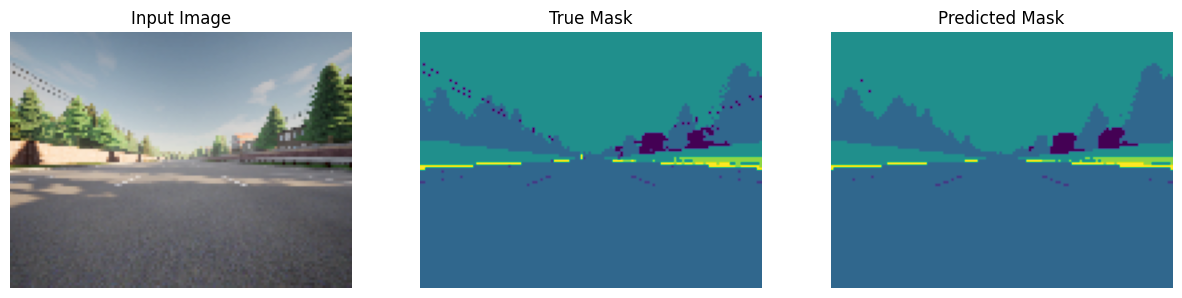

1/1 [==============================] - 0s 24ms/step


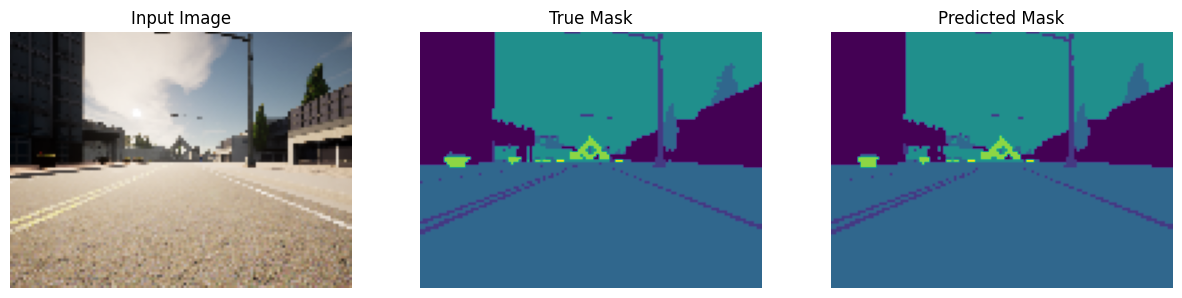

1/1 [==============================] - 0s 216ms/step


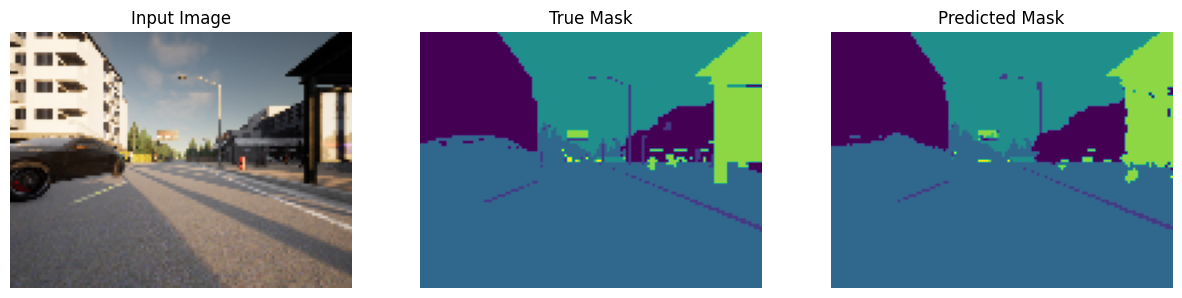

In [49]:
show_predictions(val_ds, 5)

In [50]:
best_model.save_weights("model_weights.h5")

In [51]:
import pickle

with open('history_more.pkl', 'wb') as f:
    pickle.dump(history_more.history, f)